In [1]:
import sys
import datetime
print('Aktuální datum:' , datetime.datetime.now().date())
print('Python:' , sys.version)

import numpy as np
print('Numpy:', np.__version__)

import pandas as pd
print('Pandas:', pd.__version__)

import vhat
print('VHAT:', vhat.__version__)

import numba
print('Numba:', numba.__version__)

import matplotlib
print('Matplotlib:', matplotlib.__version__)

import seaborn as sns
print('Seaborn:', sns.__version__)

#import bokeh as bk
#import bokeh.plotting as bkplot
#print('Bokeh:', bk.__version__)
#bkplot.output_notebook() # show visualisation inline

Aktuální datum: 2020-04-10
Python: 3.8.2 (default, Mar 31 2020, 15:23:55) 
[GCC 8.3.0]
Numpy: 1.18.2
Pandas: 1.0.3
VHAT: 0.0.17
Numba: 0.48.0
Matplotlib: 3.2.1
Seaborn: 0.10.0


# Backtest `SquareMathLevels`

## Cíl
Ověření hypotézy, že `SquareMath Levels` fungují jako S/R úrovně, tzn. trh má tendenci se od nich odrážet.

**Ověření na statistice ZN 1min, SML - 30min SQUARE 16**

## Příprava dat

### Nastavení pro kalkulaci SquareMath

In [2]:
SQUARE = 128
SQUARE_MULTIPLIER = 1.5
# how many 
BARS_BACK_TO_REFERENCE = np.int(np.ceil(SQUARE * SQUARE_MULTIPLIER))
# set higher timeframe for getting SquareMathLevels
MINUTES = 30 # range 0-59



PD_RESAMPLE_RULE = f'{MINUTES}Min'
# set the period of PD_RESAMPLE_RULE will be started. E.g. PD_RESAMPLE_RULE == '30min':
# PD_GROUPER_BASE = 5, periods will be: 8:05:00, 8:35:00, 9:05:00, etc...
# PD_GROUPER_BASE = 0, means 8:00:00, 8:30:00, 9:00:00, etc...
PD_GROUPER_BASE = 0 

### Data, která se budou analyzovat

In [3]:
TICK_SIZE_STR = f'{1/32*0.5}'
TICK_SIZE = float(TICK_SIZE_STR)
#SYMBOL = 'ZN'
TICK_SIZE_STR

'0.015625'

In [4]:
DATA_FILE = '../../Data/ZN-1s.csv'

read_cols = ['Date', 'Time', 'Open', 'High', 'Low', 'Last']
data = pd.read_csv(DATA_FILE, index_col=0, skipinitialspace=True, usecols=read_cols, parse_dates={'Datetime': [0, 1]})
data.rename(columns={"Last": "Close"}, inplace=True)
data.index.name = 'Datetime'
data['Idx'] = np.arange(data.shape[0])
df = data
df

,Open,High,Low,Close,Idx
Datetime,,,,,
2010-07-20 18:30:00,123.093803,123.093803,123.093803,123.093803,0
2010-07-20 18:31:00,123.093803,123.093803,123.093803,123.093803,1
2010-07-20 18:32:00,123.109398,123.109398,123.109398,123.109398,2
2010-07-20 18:33:00,123.125000,123.125000,123.109398,123.109398,3
2010-07-20 18:34:00,123.109398,123.109398,123.109398,123.109398,4
...,...,...,...,...,...
2020-04-08 08:03:00,137.828125,137.859375,137.812500,137.859375,3068381
2020-04-08 08:04:00,137.843750,137.859375,137.812500,137.812500,3068382
2020-04-08 08:05:00,137.812500,137.812500,137.796875,137.796875,3068383


### Maximální high a low za posledních BARS_BACK_TO_REFERENCE svíček z vyššího timeframu.

High

In [5]:
# calculate max high for actual record from higher tiframe his period
df_helper_gr = df[['High']].groupby(pd.Grouper(freq=PD_RESAMPLE_RULE, base=PD_GROUPER_BASE))
df_helper = df_helper_gr.rolling(PD_RESAMPLE_RULE, min_periods=1).max().dropna() # cummax() with new index
df_helper['bigCumMaxHigh'] = df_helper.assign(l=df_helper_gr.max().dropna().rolling(BARS_BACK_TO_REFERENCE-1).max().shift().loc[df_helper.index.get_level_values(0)].to_numpy()).max(axis=1, skipna=False)

df_helper.set_index(df_helper.index.get_level_values(1), inplace=True) # drop multiindex
df['SMLHighLimit'] = df_helper.bigCumMaxHigh
df

,Open,High,Low,Close,Idx,SMLHighLimit
Datetime,,,,,,
2010-07-20 18:30:00,123.093803,123.093803,123.093803,123.093803,0,NaN
2010-07-20 18:31:00,123.093803,123.093803,123.093803,123.093803,1,NaN
2010-07-20 18:32:00,123.109398,123.109398,123.109398,123.109398,2,NaN
2010-07-20 18:33:00,123.125000,123.125000,123.109398,123.109398,3,NaN
2010-07-20 18:34:00,123.109398,123.109398,123.109398,123.109398,4,NaN
...,...,...,...,...,...,...
2020-04-08 08:03:00,137.828125,137.859375,137.812500,137.859375,3068381,139.34375
2020-04-08 08:04:00,137.843750,137.859375,137.812500,137.812500,3068382,139.34375
2020-04-08 08:05:00,137.812500,137.812500,137.796875,137.796875,3068383,139.34375


Low

In [6]:
# calculate min low for actual record from higher tiframe his period
df_helper_gr = df[['Low']].groupby(pd.Grouper(freq=PD_RESAMPLE_RULE, base=PD_GROUPER_BASE))
df_helper = df_helper_gr.rolling(PD_RESAMPLE_RULE, min_periods=1).min().dropna() # cummin() with new index
df_helper['bigCumMinLow'] = df_helper.assign(l=df_helper_gr.min().dropna().rolling(BARS_BACK_TO_REFERENCE-1).min().shift().loc[df_helper.index.get_level_values(0)].to_numpy()).min(axis=1, skipna=False)


df_helper.set_index(df_helper.index.get_level_values(1), inplace=True) # drop multiindex
df['SMLLowLimit'] = df_helper.bigCumMinLow
df

,Open,High,Low,Close,Idx,SMLHighLimit,SMLLowLimit
Datetime,,,,,,,
2010-07-20 18:30:00,123.093803,123.093803,123.093803,123.093803,0,NaN,NaN
2010-07-20 18:31:00,123.093803,123.093803,123.093803,123.093803,1,NaN,NaN
2010-07-20 18:32:00,123.109398,123.109398,123.109398,123.109398,2,NaN,NaN
2010-07-20 18:33:00,123.125000,123.125000,123.109398,123.109398,3,NaN,NaN
2010-07-20 18:34:00,123.109398,123.109398,123.109398,123.109398,4,NaN,NaN
...,...,...,...,...,...,...,...
2020-04-08 08:03:00,137.828125,137.859375,137.812500,137.859375,3068381,139.34375,137.5
2020-04-08 08:04:00,137.843750,137.859375,137.812500,137.812500,3068382,139.34375,137.5
2020-04-08 08:05:00,137.812500,137.812500,137.796875,137.796875,3068383,139.34375,137.5


Zahození nepotřebných prostředků a záznamů NaN, které nemůžu analyzovat

In [7]:
del df_helper
del df_helper_gr
df.dropna(inplace=True)
df

,Open,High,Low,Close,Idx,SMLHighLimit,SMLLowLimit
Datetime,,,,,,,
2010-07-26 23:34:00,122.734398,122.734398,122.734398,122.734398,4947,123.75000,122.375
2010-07-26 23:35:00,122.734398,122.734398,122.718803,122.718803,4948,123.75000,122.375
2010-07-26 23:41:00,122.734398,122.750000,122.734398,122.750000,4949,123.75000,122.375
2010-07-26 23:43:00,122.750000,122.750000,122.750000,122.750000,4950,123.75000,122.375
2010-07-26 23:44:00,122.750000,122.750000,122.750000,122.750000,4951,123.75000,122.375
...,...,...,...,...,...,...,...
2020-04-08 08:03:00,137.828125,137.859375,137.812500,137.859375,3068381,139.34375,137.500
2020-04-08 08:04:00,137.843750,137.859375,137.812500,137.812500,3068382,139.34375,137.500
2020-04-08 08:05:00,137.812500,137.812500,137.796875,137.796875,3068383,139.34375,137.500


### Výpočet SMLevels pro každý záznam

In [8]:
from vhat.squaremath.funcs import calculate_octave

SML_INDEXES = np.arange(-2, 10+1, dtype=np.int) # from -2/8 to +2/8

def round_to_tick_size(values, tick_size):
    return np.round(values / tick_size) * tick_size

def get_smlines(r):
    tick_size = TICK_SIZE
    lowLimit = r.SMLLowLimit
    highLimit = r.SMLHighLimit
    zeroLine, frameSize = calculate_octave(lowLimit, highLimit)
    spread = frameSize * 0.125
    sml = SML_INDEXES * spread + zeroLine
    sml = round_to_tick_size(sml, tick_size)
    return [sml, zeroLine, frameSize, spread]

In [9]:
temp = df.apply(get_smlines, axis=1, result_type='expand')
temp.columns = ['SML', 'zeroLine', 'framSize', 'spread']
df = df.join(temp)
del temp
df

,Open,High,Low,Close,Idx,SMLHighLimit,SMLLowLimit,SML,zeroLine,framSize,spread
Datetime,,,,,,,,,,,
2010-07-26 23:34:00,122.734398,122.734398,122.734398,122.734398,4947,123.75000,122.375,"[122.265625, 122.46875, 122.65625, 122.859375,...",122.65625,1.5625,0.195312
2010-07-26 23:35:00,122.734398,122.734398,122.718803,122.718803,4948,123.75000,122.375,"[122.265625, 122.46875, 122.65625, 122.859375,...",122.65625,1.5625,0.195312
2010-07-26 23:41:00,122.734398,122.750000,122.734398,122.750000,4949,123.75000,122.375,"[122.265625, 122.46875, 122.65625, 122.859375,...",122.65625,1.5625,0.195312
2010-07-26 23:43:00,122.750000,122.750000,122.750000,122.750000,4950,123.75000,122.375,"[122.265625, 122.46875, 122.65625, 122.859375,...",122.65625,1.5625,0.195312
2010-07-26 23:44:00,122.750000,122.750000,122.750000,122.750000,4951,123.75000,122.375,"[122.265625, 122.46875, 122.65625, 122.859375,...",122.65625,1.5625,0.195312
...,...,...,...,...,...,...,...,...,...,...,...
2020-04-08 08:03:00,137.828125,137.859375,137.812500,137.859375,3068381,139.34375,137.500,"[137.109375, 137.3125, 137.5, 137.703125, 137....",137.50000,1.5625,0.195312
2020-04-08 08:04:00,137.843750,137.859375,137.812500,137.812500,3068382,139.34375,137.500,"[137.109375, 137.3125, 137.5, 137.703125, 137....",137.50000,1.5625,0.195312
2020-04-08 08:05:00,137.812500,137.812500,137.796875,137.796875,3068383,139.34375,137.500,"[137.109375, 137.3125, 137.5, 137.703125, 137....",137.50000,1.5625,0.195312


### Výpočet dotyku SML

Musím vypočítat dotyk předchozího průrazu kvůli frame-shift.

In [10]:
df['prevSML'] = df.SML.shift()
df.dropna(inplace=True)
df

,Open,High,Low,Close,Idx,SMLHighLimit,SMLLowLimit,SML,zeroLine,framSize,spread,prevSML
Datetime,,,,,,,,,,,,
2010-07-26 23:35:00,122.734398,122.734398,122.718803,122.718803,4948,123.75000,122.375,"[122.265625, 122.46875, 122.65625, 122.859375,...",122.65625,1.5625,0.195312,"[122.265625, 122.46875, 122.65625, 122.859375,..."
2010-07-26 23:41:00,122.734398,122.750000,122.734398,122.750000,4949,123.75000,122.375,"[122.265625, 122.46875, 122.65625, 122.859375,...",122.65625,1.5625,0.195312,"[122.265625, 122.46875, 122.65625, 122.859375,..."
2010-07-26 23:43:00,122.750000,122.750000,122.750000,122.750000,4950,123.75000,122.375,"[122.265625, 122.46875, 122.65625, 122.859375,...",122.65625,1.5625,0.195312,"[122.265625, 122.46875, 122.65625, 122.859375,..."
2010-07-26 23:44:00,122.750000,122.750000,122.750000,122.750000,4951,123.75000,122.375,"[122.265625, 122.46875, 122.65625, 122.859375,...",122.65625,1.5625,0.195312,"[122.265625, 122.46875, 122.65625, 122.859375,..."
2010-07-26 23:48:00,122.734398,122.765602,122.734398,122.750000,4952,123.75000,122.375,"[122.265625, 122.46875, 122.65625, 122.859375,...",122.65625,1.5625,0.195312,"[122.265625, 122.46875, 122.65625, 122.859375,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-08 08:03:00,137.828125,137.859375,137.812500,137.859375,3068381,139.34375,137.500,"[137.109375, 137.3125, 137.5, 137.703125, 137....",137.50000,1.5625,0.195312,"[137.109375, 137.3125, 137.5, 137.703125, 137...."
2020-04-08 08:04:00,137.843750,137.859375,137.812500,137.812500,3068382,139.34375,137.500,"[137.109375, 137.3125, 137.5, 137.703125, 137....",137.50000,1.5625,0.195312,"[137.109375, 137.3125, 137.5, 137.703125, 137...."
2020-04-08 08:05:00,137.812500,137.812500,137.796875,137.796875,3068383,139.34375,137.500,"[137.109375, 137.3125, 137.5, 137.703125, 137....",137.50000,1.5625,0.195312,"[137.109375, 137.3125, 137.5, 137.703125, 137...."


In [11]:
df['SMLTouch'] = df.apply(lambda r: np.bitwise_and(r.Low<=r.prevSML, r.prevSML<=r.High), axis=1)
df['SMLTouchCount'] = df.SMLTouch.apply(lambda v: sum(v))
df

,Open,High,Low,Close,Idx,SMLHighLimit,SMLLowLimit,SML,zeroLine,framSize,spread,prevSML,SMLTouch,SMLTouchCount
Datetime,,,,,,,,,,,,,,
2010-07-26 23:35:00,122.734398,122.734398,122.718803,122.718803,4948,123.75000,122.375,"[122.265625, 122.46875, 122.65625, 122.859375,...",122.65625,1.5625,0.195312,"[122.265625, 122.46875, 122.65625, 122.859375,...","[False, False, False, False, False, False, Fal...",0
2010-07-26 23:41:00,122.734398,122.750000,122.734398,122.750000,4949,123.75000,122.375,"[122.265625, 122.46875, 122.65625, 122.859375,...",122.65625,1.5625,0.195312,"[122.265625, 122.46875, 122.65625, 122.859375,...","[False, False, False, False, False, False, Fal...",0
2010-07-26 23:43:00,122.750000,122.750000,122.750000,122.750000,4950,123.75000,122.375,"[122.265625, 122.46875, 122.65625, 122.859375,...",122.65625,1.5625,0.195312,"[122.265625, 122.46875, 122.65625, 122.859375,...","[False, False, False, False, False, False, Fal...",0
2010-07-26 23:44:00,122.750000,122.750000,122.750000,122.750000,4951,123.75000,122.375,"[122.265625, 122.46875, 122.65625, 122.859375,...",122.65625,1.5625,0.195312,"[122.265625, 122.46875, 122.65625, 122.859375,...","[False, False, False, False, False, False, Fal...",0
2010-07-26 23:48:00,122.734398,122.765602,122.734398,122.750000,4952,123.75000,122.375,"[122.265625, 122.46875, 122.65625, 122.859375,...",122.65625,1.5625,0.195312,"[122.265625, 122.46875, 122.65625, 122.859375,...","[False, False, False, False, False, False, Fal...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-08 08:03:00,137.828125,137.859375,137.812500,137.859375,3068381,139.34375,137.500,"[137.109375, 137.3125, 137.5, 137.703125, 137....",137.50000,1.5625,0.195312,"[137.109375, 137.3125, 137.5, 137.703125, 137....","[False, False, False, False, False, False, Fal...",0
2020-04-08 08:04:00,137.843750,137.859375,137.812500,137.812500,3068382,139.34375,137.500,"[137.109375, 137.3125, 137.5, 137.703125, 137....",137.50000,1.5625,0.195312,"[137.109375, 137.3125, 137.5, 137.703125, 137....","[False, False, False, False, False, False, Fal...",0
2020-04-08 08:05:00,137.812500,137.812500,137.796875,137.796875,3068383,139.34375,137.500,"[137.109375, 137.3125, 137.5, 137.703125, 137....",137.50000,1.5625,0.195312,"[137.109375, 137.3125, 137.5, 137.703125, 137....","[False, False, False, False, False, False, Fal...",0


In [12]:
from dataclasses import dataclass
from typing import List

@dataclass
class Trade:
    tId: int
    # vstupní data, která znám dopředu
    entry_idx: int
    entry_sml_number: int
    entry_sml_spread: float
    entry_price: float
    entry_lots: int # -1 short, 1 long
    profit_target: float
    stop_loss: float
    
    # průběh a vývoj trhu v otevřeném obchodu
    max_running_profit_price: float
    max_running_loss_price: float
    
    # výstupní data, která se vyplní až na konci
    exit_idx: int = -1
    exit_price: float = 0.0
    exit_sml_number: int = 9999
        
    # pokud obchod skončí tak, že nebude možné zjistit výsledek, co bylo realizováno dříve, nastaví se tahle proměnná
    unrecognizable_trade: bool = False
        
@dataclass
class TradeList:
     trades: List[Trade]

In [13]:
def check_open_trades(v, finished_trades, r):
    # TODO: dodělat indexy aktuální svíce
    trades_to_close = []
    for tid, trade in opened_trades.items():
        
        # průběžné statistiky
        if trade.entry_lots == 0 : raise Exception('Něco jsem dojebal - open trades má entry lots == 0')
        long_trade = trade.entry_lots>0
        if long_trade:
            trade.max_running_profit_price = max(min(r.High, trade.profit_target), trade.max_running_profit_price)
            trade.max_running_loss_price = min(max(r.Low, trade.stop_loss), trade.max_running_loss_price)
        else: # short trade
            trade.max_running_profit_price = min(max(r.Low, trade.profit_target), trade.max_running_profit_price)
            trade.max_running_loss_price = max(min(r.High, trade.stop_loss), trade.max_running_loss_price)    
        
        # zasažení PT nebo SL
        hit_pt = True if r.Low<=trade.profit_target<=r.High else False
        hit_sl = True if r.Low<=trade.stop_loss<=r.High else False
        hits = (hit_pt, hit_sl)
        if all(hits):
            # špatný stav - nedokážu přesně určit, zda obchod trefil první SL nebo PT
            trade.unrecognizable_trade = True
            trades_to_close.append(tid)
        elif hit_pt:
            trade.exit_idx = r.Idx
            trade.exit_price = trade.profit_target
            trade.exit_sml_number = trade.entry_sml_number+(1 if long_trade else -1)
            trades_to_close.append(tid)
        elif hit_sl:
            trade.exit_idx = r.Idx
            trade.exit_price = trade.stop_loss
            trade.exit_sml_number = trade.entry_sml_number-(1 if long_trade else -1)
            trades_to_close.append(tid)
        
    # Uzavření tradů
    for tid in trades_to_close:
        finished_trades.append(opened_trades[tid])
        del opened_trades[tid]

In [14]:
def entry_logic(opened_trades, finished_trades, r, prev_r, last_level, tick_size, rr_multiplier=1):
    
    if r.SMLTouchCount !=1:
        # TODO: tohle neni az tak uplne pravda
        # pokud je open pod oběma proraženými levely, je jasné, že levely byly
        # aktivovány v jasném pořadí, ale to asi není až tak důležité.
        return # nejde urcit, co bylo aktivováno dříve
    
    # zjistit, který level je aktivován => musí být z minulých levelů
    price_level_hit = r.prevSML[r.SMLTouch][0]
    
    for trade in opened_trades.values():
        if trade.entry_price == price_level_hit:
            return # zadny obchod nechci otevirat, uz je otevren
    
    newtid = len(opened_trades) + len(finished_trades) + 1
    idx_level_hit = SML_INDEXES[r.SMLTouch][0]
    # otevrit obchod na prorazenem levelu
    if price_level_hit < last_level:
        # dotek z vrchu == long
        lots = 1
        pt = round_to_tick_size(price_level_hit + prev_r.spread * rr_multiplier, tick_size)
        sl = round_to_tick_size(price_level_hit - prev_r.spread, tick_size)
        running_profit_price = r.High
        running_loss_price = r.Low
    else:
        # short
        lots = -1
        pt = round_to_tick_size(price_level_hit - prev_r.spread * rr_multiplier, tick_size)
        sl = round_to_tick_size(price_level_hit + prev_r.spread, tick_size)
        running_profit_price = r.Low
        running_loss_price = r.High
    
    
    new_trade = Trade(newtid, r.Idx, idx_level_hit, prev_r.spread, price_level_hit, lots, pt, sl, running_profit_price, running_loss_price)
    opened_trades[newtid] = new_trade
        
    
        

last_level = None # price of last SML for predicting 
opened_trades = {}
finished_trades = []

for idxdt, r in df.iterrows():    
    if not last_level:
        last_level = r.Close
        prev_r = r
        continue
    
    check_open_trades(opened_trades, finished_trades, r)
    entry_logic(opened_trades, finished_trades, r, prev_r, last_level, TICK_SIZE)
        
    # nastavit poslední vývoj pro kalkulaci v další svíci
    prev_r = r
    if r.SMLTouchCount == 1:
        last_level = r.prevSML[r.SMLTouch][0]
    elif r.SMLTouchCount > 1:
        last_level = r.Close    

In [15]:
from dataclasses import astuple
finished_trades = TradeList(finished_trades)
opened_trades = TradeList(list(opened_trades.values()))
cols = ['id', 'entryIdx', 'entrySmLvl', 'entrySmlSpread', 'entryPrice', 'lots', 'pt', 'sl', 'runningProfit', 'runningRisk', 'exitIdx', 'exitPrice', 'exitSmLvl', 'unrecognizableTrade']
stats_opened = pd.DataFrame(astuple(opened_trades)[0], columns=cols)
stats = pd.DataFrame(astuple(finished_trades)[0], columns=cols)
stats

,id,entryIdx,entrySmLvl,entrySmlSpread,entryPrice,lots,pt,sl,runningProfit,runningRisk,exitIdx,exitPrice,exitSmLvl,unrecognizableTrade
0,1,5086,0,0.195312,122.656250,1,122.84375,122.46875,122.687500,122.468750,5336,122.46875,-1,False
1,2,5336,-1,0.195312,122.468750,1,122.65625,122.28125,122.515602,122.281250,5455,122.28125,-2,False
2,3,5455,2,0.195312,122.265625,1,122.46875,122.06250,122.468750,122.203102,5501,122.46875,3,False
3,4,5501,3,0.195312,122.468750,-1,122.28125,122.65625,122.281250,122.546898,5648,122.28125,2,False
4,5,5648,2,0.195312,122.265625,1,122.46875,122.06250,122.468750,122.250000,6047,122.46875,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17679,17683,3067401,1,0.195312,137.703125,-1,137.50000,137.90625,137.687500,137.906250,3067420,137.90625,2,False
17680,17684,3067418,2,0.195312,137.890625,-1,137.68750,138.09375,137.812500,138.093750,3067581,138.09375,3,False
17681,17685,3067581,3,0.195312,138.093750,-1,137.90625,138.28125,137.937500,138.281250,3068047,138.28125,4,False
17682,17686,3068047,4,0.195312,138.281250,-1,138.09375,138.46875,138.093750,138.296875,3068080,138.09375,3,False


# Statistika výsledků

**Backtest základní info**

In [16]:
print('Od:', df.iloc[0].name)
print('Do', df.iloc[-1].name)
print('Časové období:', df.iloc[-1].name - df.iloc[0].name)
print('Počet obchodních dnů:', df.Close.resample('1D').ohlc().shape[0])
print('Počet záznamů jemného tf:', df.shape[0])

Od: 2010-07-26 23:35:00
Do 2020-04-08 08:07:00
Časové období: 3543 days 08:32:00
Počet obchodních dnů: 3545
Počet záznamů jemného tf: 3063438


## Validita nízkého timeframe pro backtest - možná zasenesená chyba

Zjištění, zda je zvolený `SQUARE` na vyšším timeframu dostatečný pro backtest na tomto nízkém timeframu. Tzn. pokud mám `Square=32` z vyššího `timeframe='30min'`, mohu zjistit jestli jsou záznamy `timeframe='1min'` vhodné pro backtest.

Pokud by byla vysoká chyba rozlišení nízkého timeframe (např. nad 5%), je třeba pro relevatní výsledky zvolit buď nižší rozlišení pro backtest např. `'30s'` příp. `'1s'`, nebo zvýšit `SQUARE=64` nebo zvýšit vysoký timeframe pro výpočet SML `1h, 2h, 4h, 8h, 1d, ...'.

### Počet průrazů na jednu malou svíčku

Dává informaci o tom, zda je tento malý rámec dostatečný pro výpočet obchodů a může mít vypovídající informaci o chybovosti.

In [17]:
touchCounts = df.SMLTouchCount.value_counts().to_frame(name='Occurences')
touchCounts['Occ%'] = touchCounts / df.shape[0]*100
print(f'Počet protnutích více něž jedné SML v jednom záznamu: v {(df.SMLTouchCount>1).sum()} případech ({(df.SMLTouchCount>1).sum()/df.shape[0]*100:.3f}%) z {df.shape[0]} celkem\n')
touchCounts

Počet protnutích více něž jedné SML v jednom záznamu: v 752 případech (0.025%) z 3063438 celkem



,Occurences,Occ%
0,2464058,80.434401
1,598628,19.541052
2,593,0.019357
3,106,0.003460
4,28,0.000914
5,11,0.000359
6,6,0.000196
8,5,0.000163
7,2,0.000065
9,1,0.000033


### Velmi nízký SML spread

In [18]:
spread_stats = df.spread.value_counts().to_frame(name='Occurences')
spread_stats['Occ%'] = spread_stats / df.shape[0]*100
spread_stats['Ticks'] = spread_stats.index / TICK_SIZE # index musím
print(f'Počet spredu SML menších než 2 ticky v jednom záznamu: v {(df.spread/TICK_SIZE<2).sum()} případech ({(df.spread/TICK_SIZE<2).sum()/df.shape[0]*100:.3f}%) z {df.shape[0]} celkem\n')
spread_stats

Počet spredu SML menších než 2 ticky v jednom záznamu: v 0 případech (0.000%) z 3063438 celkem



,Occurences,Occ%,Ticks
0.195312,1384193,45.184299,12.500
0.097656,983695,32.110818,6.250
0.195313,252603,8.245736,12.500
0.390625,243759,7.957040,25.000
0.390625,82553,2.694783,25.000
0.048828,64784,2.114748,3.125
0.781250,30042,0.980663,50.000
0.097656,20633,0.673524,6.250
0.781250,1176,0.038388,50.000


### Výsledná možná chybovost na nízkém TF pro backtest

In [19]:
chybovost = df.spread[(df.spread/TICK_SIZE<2) | (df.SMLTouchCount>1)].shape[0]
print(f'Celková chybovost v nízkém timeframe může být v {chybovost} případech ({chybovost/df.shape[0]*100:.3f}%) z {df.shape[0]} celkem')

Celková chybovost v nízkém timeframe může být v 752 případech (0.025%) z 3063438 celkem


## Validita výsledků obchodů

In [20]:
finishedCount = stats.shape[0]
print('Total finished trades:', finishedCount)
# pokud je opravdu hodně "unrecognizableTrade", mám moc nízké rozlišení SquareMath levels (malý square)
unrec_trades = stats.unrecognizableTrade.sum()
print('Unrecognizable trades:', unrec_trades, f'({unrec_trades/finishedCount *100:.3f}%)')
print('Opened trades:', stats_opened.shape[0])

Total finished trades: 17684
Unrecognizable trades: 21 (0.119%)
Opened trades: 4


Dál nebudu potřebovat unrecognized trades

In [21]:
stats.drop(stats[stats.unrecognizableTrade].index, inplace=True)

In [22]:
shorts_mask = stats.lots<0
longs_mask = stats.lots>0

stats.loc[shorts_mask, 'PnL'] = ((stats[shorts_mask].entryPrice - stats[shorts_mask].exitPrice) / TICK_SIZE).round()
stats.loc[longs_mask, 'PnL'] = ((stats[longs_mask].exitPrice - stats[longs_mask].entryPrice) / TICK_SIZE).round()
stats.PnL = stats.PnL.astype(int)

stats['runPTicks'] = ((stats.entryPrice - stats.runningProfit).abs() / TICK_SIZE).round().astype(int)
stats['runLTicks'] = ((stats.entryPrice - stats.runningRisk).abs() * -1 / TICK_SIZE).round().astype(int)

stats['ptTicks'] = ((stats.entryPrice - stats.pt).abs() / TICK_SIZE).round().astype(int)
stats['slTicks'] = ((stats.entryPrice - stats.sl).abs() * -1 / TICK_SIZE).round().astype(int)

stats['tradeTime'] = stats.exitIdx - stats.entryIdx

stats

,id,entryIdx,entrySmLvl,entrySmlSpread,entryPrice,lots,pt,sl,runningProfit,runningRisk,exitIdx,exitPrice,exitSmLvl,unrecognizableTrade,PnL,runPTicks,runLTicks,ptTicks,slTicks,tradeTime
0,1,5086,0,0.195312,122.656250,1,122.84375,122.46875,122.687500,122.468750,5336,122.46875,-1,False,-12,2,-12,12,-12,250
1,2,5336,-1,0.195312,122.468750,1,122.65625,122.28125,122.515602,122.281250,5455,122.28125,-2,False,-12,3,-12,12,-12,119
2,3,5455,2,0.195312,122.265625,1,122.46875,122.06250,122.468750,122.203102,5501,122.46875,3,False,13,13,-4,13,-13,46
3,4,5501,3,0.195312,122.468750,-1,122.28125,122.65625,122.281250,122.546898,5648,122.28125,2,False,12,12,-5,12,-12,147
4,5,5648,2,0.195312,122.265625,1,122.46875,122.06250,122.468750,122.250000,6047,122.46875,3,False,13,13,-1,13,-13,399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17679,17683,3067401,1,0.195312,137.703125,-1,137.50000,137.90625,137.687500,137.906250,3067420,137.90625,2,False,-13,1,-13,13,-13,19
17680,17684,3067418,2,0.195312,137.890625,-1,137.68750,138.09375,137.812500,138.093750,3067581,138.09375,3,False,-13,5,-13,13,-13,163
17681,17685,3067581,3,0.195312,138.093750,-1,137.90625,138.28125,137.937500,138.281250,3068047,138.28125,4,False,-12,10,-12,12,-12,466
17682,17686,3068047,4,0.195312,138.281250,-1,138.09375,138.46875,138.093750,138.296875,3068080,138.09375,3,False,12,12,-1,12,-12,33


## Celkové výsledky

In [23]:
# masks
shorts_mask = stats.lots<0
longs_mask = stats.lots>0
profit_mask = stats.PnL>0
loss_mask = stats.PnL<0
breakeven_mask = stats.PnL==0

total_trades = stats.shape[0]
profit_trades_count = stats.PnL[profit_mask].shape[0]
loss_trades_count = stats.PnL[loss_mask].shape[0]
breakeven_trades_count = stats.PnL[breakeven_mask].shape[0]

print(f'Ziskových obchodů {profit_trades_count}({profit_trades_count/total_trades*100:.2f}%) z {total_trades} celkem')
print(f'Ztrátových obchodů {loss_trades_count}({loss_trades_count/total_trades*100:.2f}%) z {total_trades} celkem')
print(f'Break-even obchodů {breakeven_trades_count}({breakeven_trades_count/total_trades*100:.2f}%) z {total_trades} celkem')

print('---')

print(f'Počet Long obchodů = {stats[longs_mask].shape[0]} ({stats[longs_mask].shape[0]/stats.shape[0]*100:.2f}%) z {total_trades} celkem')
print(f'Počet Short obchodů = {stats[shorts_mask].shape[0]} ({stats[shorts_mask].shape[0]/stats.shape[0]*100:.2f}%) z {total_trades} celkem')

print('---')

print(f'Suma zisků = {stats.PnL[profit_mask].sum()} Ticks')
print(f'Suma ztrát = {stats.PnL[loss_mask].sum()} Ticks')
print(f'Celkem = {stats.PnL.sum()} Ticks')

Ziskových obchodů 9785(55.40%) z 17663 celkem
Ztrátových obchodů 7878(44.60%) z 17663 celkem
Break-even obchodů 0(0.00%) z 17663 celkem
---
Počet Long obchodů = 8258 (46.75%) z 17663 celkem
Počet Short obchodů = 9405 (53.25%) z 17663 celkem
---
Suma zisků = 82676 Ticks
Suma ztrát = -69248 Ticks
Celkem = 13428 Ticks


### Ztrátové obchody

In [24]:
selected_stats = stats[loss_mask]
selected_pnl_stats = selected_stats.PnL.value_counts().to_frame(name='PnLOccurences')
selected_pnl_stats['Occ%'] = selected_pnl_stats / selected_stats.shape[0]*100
selected_pnl_stats['Ticks'] = selected_pnl_stats.index / TICK_SIZE 
selected_pnl_stats

,PnLOccurences,Occ%,Ticks
-6,4146,52.627570,-384.0
-12,1440,18.278751,-768.0
-13,1298,16.476263,-832.0
-3,681,8.644326,-192.0
-25,299,3.795380,-1600.0
-50,14,0.177710,-3200.0


#### Max pohyb v zisku ve ztrátových obchodech

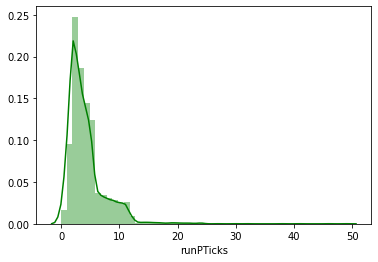

In [25]:
sns.distplot(selected_stats.runPTicks, color="g");

Poměrově pohyb v zisku k nastavenému PT u ztrátových obchodů.

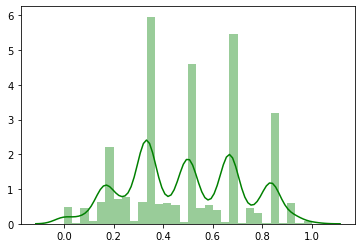

In [26]:
sns.distplot(selected_stats.runPTicks/selected_stats.ptTicks, color="g");

#### Max pohyb ve ztrátě ve ztrátových obchodech

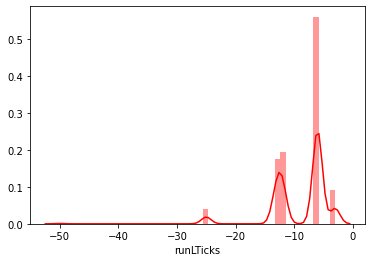

In [27]:
sns.distplot(selected_stats.runLTicks, color="r");

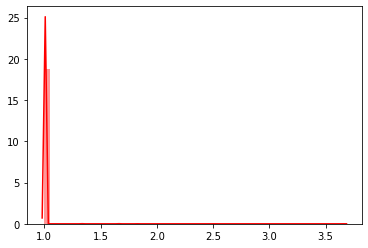

In [28]:
sns.distplot(selected_stats.runLTicks/selected_stats.slTicks, color="r");

### Ziskové obchody

In [29]:
selected_stats = stats[profit_mask]
selected_pnl_stats = selected_stats.PnL.value_counts().to_frame(name='PnLOccurences')
selected_pnl_stats['Occ%'] = selected_pnl_stats / selected_stats.shape[0]*100
selected_pnl_stats['Ticks'] = selected_pnl_stats.index / TICK_SIZE 
selected_pnl_stats

,PnLOccurences,Occ%,Ticks
6,5276,53.919264,384.0
12,1591,16.259581,768.0
13,1435,14.665304,832.0
3,1116,11.405212,192.0
25,337,3.444047,1600.0
50,30,0.306592,3200.0


#### PT adjustment ve ziskových obchodech - Max pohyb v zisku

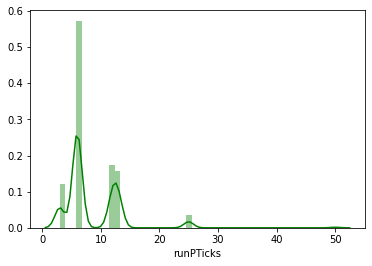

In [30]:
sns.distplot(selected_stats.runPTicks, color="g");

Poměrově pohyb v zisku k PT u ziskových obchodů.

/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


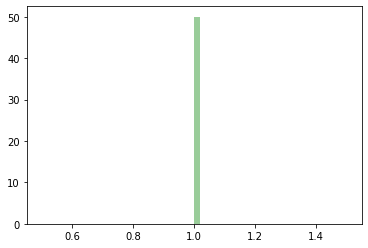

In [31]:
sns.distplot(selected_stats.runPTicks/selected_stats.ptTicks, color="g");

#### Max pohyb ve ztrátě ve ziskových obchodech

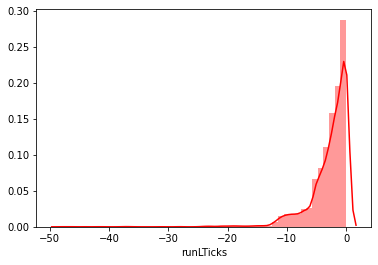

In [32]:
sns.distplot(selected_stats.runLTicks, color="r");

poměr vývoje ztráty k zadanému SL v ziskových obchodech

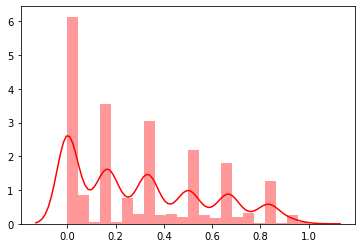

In [33]:
sns.distplot(selected_stats.runLTicks/selected_stats.slTicks, color="r");

## Long obchody

In [34]:
selected_stats = stats[longs_mask]
print('Počet obchodů:', selected_stats.shape[0], f'({selected_stats.shape[0]/stats.shape[0]*100:.2f}%) z {stats.shape[0]}')
print('Počet win:', selected_stats[selected_stats.PnL>0].shape[0], f'({selected_stats[selected_stats.PnL>0].shape[0]/selected_stats.shape[0]*100:.2f}%) z {selected_stats.shape[0]}')
print('Počet loss:', selected_stats[selected_stats.PnL<0].shape[0], f'({selected_stats[selected_stats.PnL<0].shape[0]/selected_stats.shape[0]*100:.2f}%) z {selected_stats.shape[0]}')
print('Počet break-even:', selected_stats[selected_stats.PnL==0].shape[0], f'({selected_stats[selected_stats.PnL==0].shape[0]/selected_stats.shape[0]*100:.2f}%) z {selected_stats.shape[0]}')
print('---')
print(f'Průměrný zisk: {selected_stats.PnL[selected_stats.PnL>0].mean():.3f}')
print(f'Průměrná ztráta: {selected_stats.PnL[selected_stats.PnL<0].mean():.3f}')
print('---')
selected_pnl_stats = selected_stats.PnL.value_counts().to_frame(name='PnLOccurences')
selected_pnl_stats['Occ%'] = selected_pnl_stats / selected_stats.shape[0]*100
selected_pnl_stats['Ticks'] = selected_pnl_stats.index / TICK_SIZE 
selected_pnl_stats

Počet obchodů: 8258 (46.75%) z 17663
Počet win: 4672 (56.58%) z 8258
Počet loss: 3586 (43.42%) z 8258
Počet break-even: 0 (0.00%) z 8258
---
Průměrný zisk: 8.439
Průměrná ztráta: -8.810
---


,PnLOccurences,Occ%,Ticks
6,2539,30.745943,384.0
-6,1875,22.705256,-384.0
12,760,9.203197,768.0
13,684,8.282877,832.0
-12,660,7.992250,-768.0
-13,599,7.253572,-832.0
3,518,6.272705,192.0
-3,312,3.778155,-192.0
25,157,1.901187,1600.0
-25,132,1.598450,-1600.0


#### PT adjustment ve ztrátových long obchodech - Max pohyb v zisku

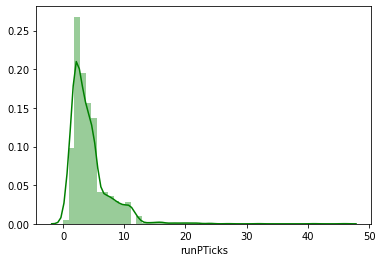

In [35]:
sns.distplot(selected_stats[selected_stats.PnL<0].runPTicks, color="g");

Poměrově pohyb v zisku k nastavenému PT u ztrátových obchodů.

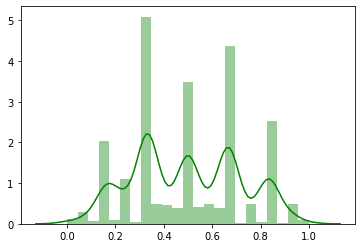

In [36]:
sns.distplot(selected_stats[selected_stats.PnL<0].runPTicks/selected_stats[selected_stats.PnL<0].ptTicks, color="g");

#### SL djustment  ve ztrátových obchodech - max pohyb v zisku

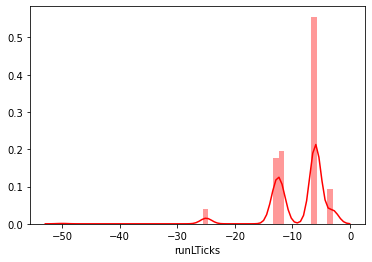

In [37]:
sns.distplot(selected_stats[selected_stats.PnL<0].runLTicks, color="r");

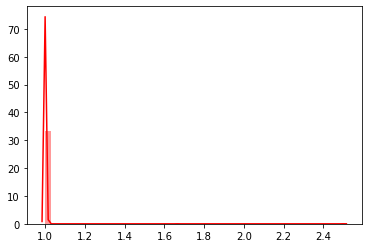

In [38]:
sns.distplot(selected_stats[selected_stats.PnL<0].runLTicks/selected_stats[selected_stats.PnL<0].slTicks, color="r"); # kontrola

#### PT adjustment v ziskových long obchodech - Max pohyb v zisku

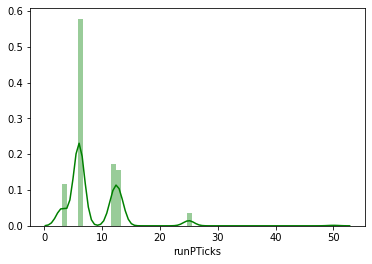

In [39]:
sns.distplot(selected_stats[selected_stats.PnL>0].runPTicks, color="g");

Poměrově pohyb v zisku k nastavenému PT u ziskových obchodů.

/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


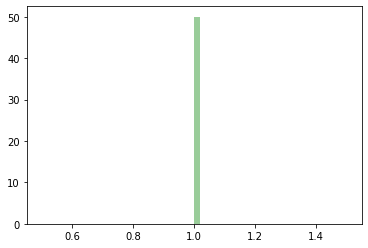

In [40]:
sns.distplot(selected_stats[selected_stats.PnL>0].runPTicks/selected_stats[selected_stats.PnL>0].ptTicks, color="g");

#### SL djustment v ziskových obchodech - max pohyb ve ztrátě

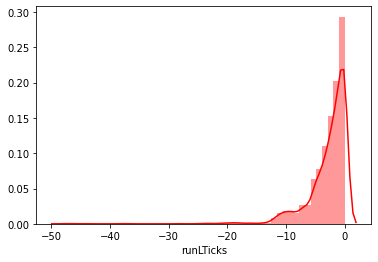

In [41]:
sns.distplot(selected_stats[selected_stats.PnL>0].runLTicks, color="r");

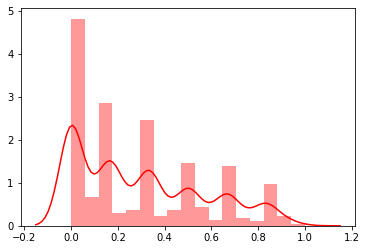

In [42]:
sns.distplot(selected_stats[selected_stats.PnL>0].runLTicks/selected_stats[selected_stats.PnL>0].slTicks, color="r"); # kontrola

# SML analýza

## Celkový počet vstupů na jednotlivých SML

In [43]:
#smlvl_stats = stats.entrySmLvl.value_counts().to_frame(name='entrySmLvlOcc')
smlvl_stats = stats[['entrySmLvl', 'lots']].groupby(['entrySmLvl']).count()
smlvl_stats.sort_values(by='lots', ascending=False, inplace=True)
smlvl_stats.rename(columns={'lots':'entrySmLvlOcc'}, inplace=True)
smlvl_stats['Occ%'] = smlvl_stats.entrySmLvlOcc / stats.shape[0] * 100
print(f'Vstup do obchodu z nejčastějších 3 levelů: {smlvl_stats.iloc[:3].index.to_list()} {smlvl_stats["Occ%"].iloc[:3].sum():.2f}%')
print(f'Vstup do obchodu z nejčastějších 5 levelů: {smlvl_stats.iloc[:5].index.to_list()} {smlvl_stats["Occ%"].iloc[:5].sum():.2f}%')
print('---')
print(f'Vstup do obchodu z nejčastějších 7 levelů: {smlvl_stats.iloc[:7].index.to_list()} {smlvl_stats["Occ%"].iloc[:7].sum():.2f}%')
print(f'Vstup do obchodu z nejčastějších 9 levelů: {smlvl_stats.iloc[:9].index.to_list()} {smlvl_stats["Occ%"].iloc[:9].sum():.2f}%')
print(f'Vstup do obchodu z nejčastějších 11 levelů: {smlvl_stats.iloc[:11].index.to_list()} {smlvl_stats["Occ%"].iloc[:11].sum():.2f}%')
print('---')
smlvl_stats

Vstup do obchodu z nejčastějších 3 levelů: [5, 4, 3] 37.64%
Vstup do obchodu z nejčastějších 5 levelů: [5, 4, 3, 6, 7] 60.31%
---
Vstup do obchodu z nejčastějších 7 levelů: [5, 4, 3, 6, 7, 2, 1] 78.32%
Vstup do obchodu z nejčastějších 9 levelů: [5, 4, 3, 6, 7, 2, 1, 8, 0] 90.84%
Vstup do obchodu z nejčastějších 11 levelů: [5, 4, 3, 6, 7, 2, 1, 8, 0, 9, -1] 97.53%
---


,entrySmLvlOcc,Occ%
entrySmLvl,,
5,2362,13.372587
4,2151,12.177999
3,2135,12.087414
6,2071,11.725075
7,1934,10.949442
2,1679,9.505746
1,1501,8.497990
8,1215,6.878786
0,997,5.644568


## Vstupy na jednotlivých levelech

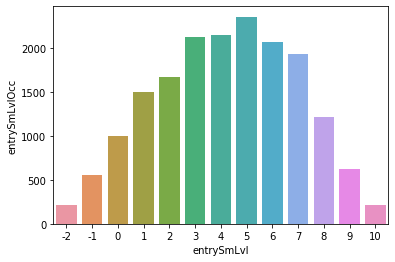

In [44]:
sns.barplot(x=smlvl_stats.entrySmLvlOcc.sort_index().index, y=smlvl_stats.entrySmLvlOcc.sort_index());

## Počet vstupů Buy nebo Sell na SML

In [45]:
stats.lots.replace({1: 'Long', -1: 'Short'}, inplace=True)

In [46]:
smlvl_stats_buy_sell = stats[['entrySmLvl', 'PnL', 'lots']].groupby(['entrySmLvl', 'lots']).count()
smlvl_stats_buy_sell.sort_index(ascending=False, inplace=True)
smlvl_stats_buy_sell.rename(columns={'PnL':'LongShortCount'}, inplace=True)
smlvl_stats_buy_sell
smlvl_stats_buy_sell['LongShortTotal%'] = smlvl_stats_buy_sell.LongShortCount / smlvl_stats_buy_sell.LongShortCount.sum() *100
smlvl_stats_buy_sell['SMLlongOrShort%'] = smlvl_stats_buy_sell[['LongShortCount']].groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
smlvl_stats_buy_sell

LongShortCount  LongShortTotal%  SMLlongOrShort%
entrySmLvl lots                                                   
 10        Short             220         1.245542       100.000000
 9         Short             615         3.481855        98.715891
           Long                8         0.045292         1.284109
 8         Short             917         5.191644        75.473251
           Long              298         1.687143        24.526749
 7         Short            1254         7.099587        64.839710
           Long              680         3.849856        35.160290
 6         Short            1167         6.607032        56.349590
           Long              904         5.118043        43.650410
 5         Short            1367         7.739342        57.874682
           Long              995         5.633245        42.125318
 4         Short            1080         6.114477        50.209205
           Long             1071         6.063523        49.790795
 3         Short            1052         5.955953        49.274005
           Long             1083         6.131461        50.725995
 2         Short             705         3.991394        41.989279
           Long              974         5.514352        58.010721
 1         Short             693         3.923456        46.169221
           Long              808         4.574534        53.830779
 0         Short             279         1.579573        27.983952
           Long              718         4.064995        72.016048
-1         Short              54         0.305724         9.660107
           Long              505         2.859084        90.339893
-2         Short               2         0.011323         0.925926
           Long              214         1.211572        99.074074

## Úspěšnost Long obchodů na SML

In [47]:
stats['Win']=profit_mask

In [48]:
stats['Win'] = stats['Win'].mask(~profit_mask) # groupby bude počítat jen výhry
smlvl_stats_buy_sell['WinCount'] = stats[['entrySmLvl', 'PnL', 'lots', 'Win']].groupby(['entrySmLvl', 'lots', 'Win']).count().droplevel(2)
smlvl_stats_buy_sell['Win%'] = smlvl_stats_buy_sell.WinCount / smlvl_stats_buy_sell.LongShortCount * 100
smlvl_stats_buy_sell

LongShortCount  LongShortTotal%  SMLlongOrShort%  WinCount  \
entrySmLvl lots                                                                
 10        Short             220         1.245542       100.000000       128   
 9         Short             615         3.481855        98.715891       328   
           Long                8         0.045292         1.284109         4   
 8         Short             917         5.191644        75.473251       497   
           Long              298         1.687143        24.526749       165   
 7         Short            1254         7.099587        64.839710       694   
           Long              680         3.849856        35.160290       379   
 6         Short            1167         6.607032        56.349590       625   
           Long              904         5.118043        43.650410       529   
 5         Short            1367         7.739342        57.874682       711   
           Long              995         5.633245        42.125318       565   
 4         Short            1080         6.114477        50.209205       594   
           Long             1071         6.063523        49.790795       622   
 3         Short            1052         5.955953        49.274005       553   
           Long             1083         6.131461        50.725995       605   
 2         Short             705         3.991394        41.989279       397   
           Long              974         5.514352        58.010721       567   
 1         Short             693         3.923456        46.169221       396   
           Long              808         4.574534        53.830779       451   
 0         Short             279         1.579573        27.983952       158   
           Long              718         4.064995        72.016048       399   
-1         Short              54         0.305724         9.660107        30   
           Long              505         2.859084        90.339893       274   
-2         Short               2         0.011323         0.925926         2   
           Long              214         1.211572        99.074074       112   

                        Win%  
entrySmLvl lots               
 10        Short   58.181818  
 9         Short   53.333333  
           Long    50.000000  
 8         Short   54.198473  
           Long    55.369128  
 7         Short   55.342903  
           Long    55.735294  
 6         Short   53.556127  
           Long    58.517699  
 5         Short   52.011704  
           Long    56.783920  
 4         Short   55.000000  
           Long    58.076564  
 3         Short   52.566540  
           Long    55.863343  
 2         Short   56.312057  
           Long    58.213552  
 1         Short   57.142857  
           Long    55.816832  
 0         Short   56.630824  
           Long    55.571031  
-1         Short   55.555556  
           Long    54.257426  
-2         Short  100.000000  
           Long    52.336449

Jen pro kontrolu. `Win == True`, `Loss == False`

In [49]:
# stats['Win'] = profit_mask
# smlvl_stats_buy_sell2 = stats[['entrySmLvl', 'PnL', 'lots', 'Win']].groupby(['entrySmLvl', 'lots', 'Win']).sum()
# smlvl_stats_buy_sell2.sort_index(ascending=False, inplace=True)
# smlvl_stats_buy_sell2.rename(columns={'PnL':'WinLossCount'}, inplace=True)
# smlvl_stats_buy_sell2

Seřazeny výsledky dle úspěsnosti:

In [50]:
smlvl_stats_buy_sell.sort_values('Win%', ascending=False)

,,LongShortCount,LongShortTotal%,SMLlongOrShort%,WinCount,Win%
entrySmLvl,lots,,,,,
-2,Short,2,0.011323,0.925926,2,100.000000
6,Long,904,5.118043,43.650410,529,58.517699
2,Long,974,5.514352,58.010721,567,58.213552
10,Short,220,1.245542,100.000000,128,58.181818
4,Long,1071,6.063523,49.790795,622,58.076564
1,Short,693,3.923456,46.169221,396,57.142857
5,Long,995,5.633245,42.125318,565,56.783920
0,Short,279,1.579573,27.983952,158,56.630824
2,Short,705,3.991394,41.989279,397,56.312057
